## ANLY 677 Lab 10
### Clare Garberg
### August 4, 2022

 # Automated Image Classification using Advanced Deep Learning Models
 The goal for this Lab is it to provide you understanding of the various deep learning models that we will be using in your project(s). In this Lab we will implement ResNet Architecture over CUB200-2011 dataset:

 The CUB200-2011 dataset can be found on its [website](https://paperswithcode.com/dataset/cub-200-2011). We can either use the data zip file or import it using  [Kaggle](https://www.kaggle.com) and [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`. I would prefer all of you do this using Google Colab. This will also help you with Last 3 Labs.

-----------------------------
**Running this on my dataset as per the instructions in the lab video.**

Obtained relatively low accuracy of 45%.

 ## Data Preprocessing
 ### Downloading and extracting custom datasets
 ### Loading custom datasets
 ### Calculating the mean and std for normalization on custom datasets
 ### Loading transforms to augment and normalize our data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

mean = [0.5683, 0.5578, 0.5178]
std = [0.2378, 0.2437, 0.2670]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = '/content/drive/MyDrive/ANLY677_finalproj_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

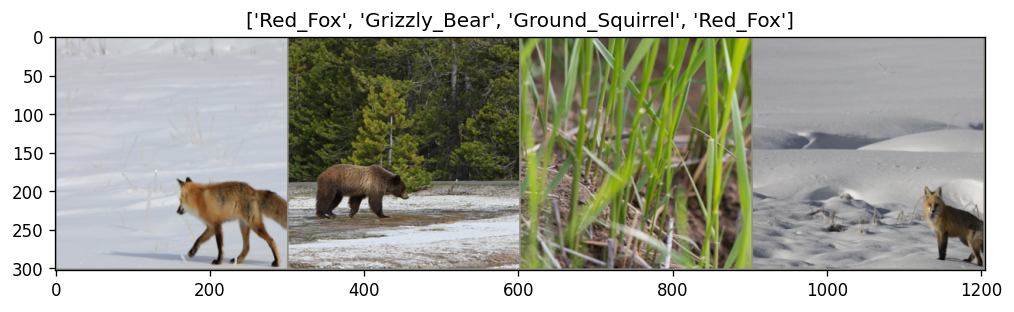

In [ ]:
plt.figure(figsize=(10,5), dpi=120)

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = [0.5683, 0.5578, 0.5178]
    std = [0.2378, 0.2437, 0.2670]
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

 ## Defining a Convolutional Neural Network
 ### Defining the ResNet blocks
 ### Defining a CUB200-2011 ResNet model

In [ ]:
# defining model and training loop
from datetime import datetime
import tqdm as tqdm

num_epochs = 50

pbar = tqdm.tqdm(total=num_epochs, position=0, leave=True, colour='#336699')
pbar.set_description("EPOCH 1: Training Loss: NA, ")

def train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        current_loss = loss.cpu().data.item()
                        running_loss += current_loss

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            pbar.set_description(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            # f"EPOCH {epoch+1}\t Batch Loss: {current_loss:.3f}\t  Epoch Loss: {train_loss[-1]:.3f}\t Train Acc: {train_accuracy[-1]:.3f}\t Test Loss: {test_loss[-1]:.3f}\t")
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        pbar.update()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

EPOCH 1: Training Loss: NA, :   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# defining function to visualize training predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(2, 2))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

 ## Training a Convolutional Neural Network
 ### Loading a pre-trained model
 ### Loading pre-trained model parameters into a defined model
 ### Learning rate finder
 ### Discriminative fine-tuning
 ### One cycle learning rate scheduler

 ## Evaluating a Convolutional Neural Network
 ### Fine-tuning a pre-trained model to achieve ~80% top-1 accuracy and ~95% top-5 accuracy on a dataset with 200 classes and only 60 examples per class
 ### Viewing our model's mistakes
 ### Visualizing our data in lower dimensions with PCA and t-SNE
 ### Viewing the learned weights of our model

In [ ]:
# loading a pretrained model and finetuning
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights

model = models.inception_v3(weights='Inception_V3_Weights.DEFAULT')
model.aux_logits=False
model

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
num_ftrs = model.fc.in_features
# print(num_ftrs)
# Here the size of each output sample is set to 2. In your model use nn.Linear(num_ftrs, len(class_names)) to generalize to your number of classes.
model.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# training using our function defined above
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

val Loss: 4.0937 Acc: 0.0000: 100%|██████████| 50/50 [1:31:23<00:00, 108.53s/it]

Training complete in 91m 11s
Best val Acc: 0.045455


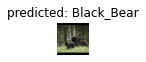

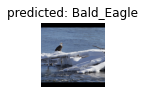

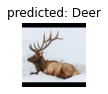

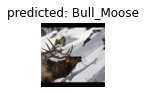

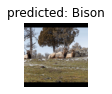

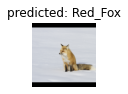

In [ ]:
visualize_model(model_ft)

## CovNet as a fixed feature extractor

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)`.

In [ ]:
# loading a pretrained model and finetuning
model_conv = torchvision.models.inception_v3(weights='Inception_V3_Weights.DEFAULT')
model_conv.aux_logits=False


for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=num_epochs)

val Loss: 3.1179 Acc: 0.0000: : 100it [2:25:03, 62.24s/it]

Training complete in 52m 32s
Best val Acc: 0.227273


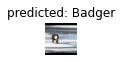

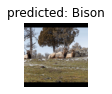

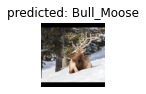

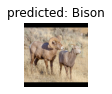

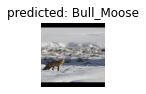

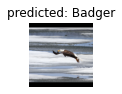

In [17]:
visualize_model(model_conv)

plt.ioff()
plt.show()